In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras import layers, utils, backend, callbacks

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import mplhep

ZFIT_DISABLE_TF_WARNINGS=1
import zfit

# mplhep.style.use("LHCb2")

import modplot
import numpy as np
import pandas as pd

from hep_ml import reweight
import mplhep

import uproot
import awkward as ak
from datetime import datetime

gpus = tf.config.experimental.list_physical_devices('GPU')

2024-02-05 15:55:53.291973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 15:55:53.482635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 15:55:54.541990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress 

In [2]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"

centralityBins=[0,10]   # corresponds to 0 bin
#centralityBins=[10,40] # corresponds to 1 bin
#centralityBins=[40,80] # corresponds to 2 bin

features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3"]

doRealData = False


## ZFit 
Returns weights for centrality


In [3]:
from hepstats.splot import compute_sweights

obs = zfit.Space('D0mass', limits=(D0masMin, D0masMax))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)
lambd = zfit.Parameter("lambda", -3.0)
sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

def getSWeights(exp):
# model building, pdf creation
    signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
    comb_bkg_pdf  = zfit.pdf.Exponential(lambd, obs=obs)

    data= zfit.Data.from_pandas(exp)

# Create the extended models
    extended_sig = signal_pdf.create_extended(sig_yield)
    extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
    model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

# plot the data
    data_mass = data["D0mass"].numpy()

# Builds the loss.
    data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
    nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
    sigma.floating = False

# Minimizes the loss.
    minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
    result_sw = minimizer.minimize(nll_sw)
   
    weights = compute_sweights(model, data_sw)
    return weights[sig_yield]


def getEfficiencyD0Yield(pT, centrality):
    # 2014 efficiency
    #                   0-10% ,  10-20% , 20-40% , 40-60% ,  60-80%
    efficiencies = [ [0.000622, 0.000740, 0.00088, 0.00108, 0.00140],         #for pT in range 0-0.5
                     [0.000717, 0.000717, 0.00110, 0.00143, 0.00160],         #for pT in range 0.5-1.0
                     [0.001025, 0.001300, 0.00195, 0.00304, 0.00289],         #for pT in range 1.0-1.5
                     [0.002248, 0.003014, 0.00411, 0.00610, 0.00528],         #for pT in range 1.5-2.0
                     [0.003794, 0.006104, 0.00738, 0.01072, 0.00997],         #for pT in range 2.0-2.5
                     [0.006107, 0.009671, 0.01006, 0.01606, 0.01447],         #for pT in range 2.5-3.0
                     [0.011249, 0.016457, 0.02087, 0.02565, 0.02482],         #for pT in range 3.0-4.0
                     [0.015830, 0.023905, 0.02984, 0.03553, 0.03663],         #for pT in range 4.0-5.0
                     [0.026520, 0.034723, 0.04134, 0.04656, 0.04032],         #for pT in range 5.0-6.0
                     [0.029904, 0.040095, 0.04888, 0.05334, 0.05080],         #for pT in range 6.0-8.0
                     [0.032680, 0.045229, 0.05514, 0.06017, 0.05685] ]        #for pT in range 8.0-30
    
    ptBins = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 8.0, 40]
    centBins = [0, 10, 20, 40, 60, 80]
    pT_range = 0
    centr_range = 0
    for i in range(len(ptBins)):
        if pT >= ptBins[i] and pT < ptBins[i+1]:
            pT_range = i
            break
    for i in range(len(centBins)):
        if  centrality >= centBins[i] and centrality < centBins[i+1]:
            centr_range = i
            break
    return efficiencies[pT_range][centr_range]

#     //https://inspirehep.net/literature/2051708
#     // https://journals.aps.org/prc/abstract/10.1103/PhysRevC.99.034908

# //D0 2014 efficiency                        0-10% ,     10-20% , 20-40% ,  40-60%  60-80%
#     const double efficiencies[11][5]={     {0.000622, 0.000740, 0.00088, 0.00108, 0.00140},         //pT = 0-0.5
#                                            {0.000717,0.000717, 0.00110, 0.00143, 0.00160},          //pT = 0.5-1.0
#                                            {0.001025, 0.001300, 0.00195, 0.00304, 0.00289},         //pT = 1.0-1.5
#                                            {0.002248, 0.003014, 0.00411, 0.00610, 0.00528},         //pT = 1.5-2.0
#                                            {0.003794,0.006104, 0.00738, 0.01072, 0.00997},          //pT = 2.0-2.5
#                                            {0.006107, 0.009671, 0.01006, 0.01606, 0.01447},         //pT = 2.5-3.0
#                                            {0.011249, 0.016457, 0.02087, 0.02565, 0.02482},         //pT = 3.0-4.0
#                                            {0.015830, 0.023905, 0.02984, 0.03553, 0.03663},         //pT = 4.0-5.0
#                                            {0.026520, 0.034723,   0.04134, 0.04656,0.04032},          //pT = 5.0-6.0
#                                            {0.029904, 0.040095,0.04888, 0.05334,0.05080},           //pT = 6.0-8.0
#                                            {0.032680,0.045229,    0.05514,0.06017,0.05685} };         //pT = 8.0-10.0

#     //https://drupal.star.bnl.gov/STAR/system/files/2018_1109_D0spectra_Note.pdf
#     //D0 2016 efficiency                        0-10%       10-20%  20-40%   40-60%      60-80%
#     const double efficiencies2016[11][5] = {  {0.000669, 0.000741, 0.000845, 0.000981, 0.001094},    //pT = 0-0.5
#                                               {0.000741, 0.000707, 0.001018, 0.001216, 0.001305},    //pT = 0.5-1.0
#                                               {0.001037, 0.001285, 0.001957, 0.002952, 0.002222},    //pT = 1.0-1.5
#                                               {0.002358, 0.002978, 0.004169, 0.005517, 0.004192},    //pT = 1.5-2.0
#                                               {0.004128, 0.006111, 0.007096, 0.009658, 0.008442},    //pT = 2.0-2.5
#                                               {0.006282, 0.009654, 0.010210, 0.014426, 0.012034},    //pT = 2.5-3.0
#                                               {0.012071, 0.016277, 0.020178, 0.024096, 0.020480},    //pT = 3.0-4.0
#                                               {0.018021, 0.023850, 0.028217, 0.033696, 0.029730},    //pT = 4.0-5.0
#                                               {0.026160, 0.034300, 0.042521, 0.047122, 0.033852},    //pT = 5.0-6.0
#                                               {0.029773, 0.039774, 0.047944, 0.051664, 0.038528},    //pT = 6.0-8.0
#                                               {0.032934, 0.044408, 0.054539, 0.058225, 0.043018} }; //pT = 8.0-10.0
# }


2024-02-05 15:55:58.112312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 15:55:58.112660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 15:55:58.112745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 15:55:59.631588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-05 15:55:59.631769: I tensorflow/compile

In [4]:
# with uproot.open("/home/prozorov/dev/star/unfold/JetFinderEfficiency.root") as file:
#     hist=file["JetFinderEfficiency"] #2d histogram
#     eff=hist.to_numpy()

#     values = eff[0]
#     ptBinsEdges = eff[1]

#     print(ptBinsEdges)

#     print(values)
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
# centrality : 0-10%,     10-40%,    40-80%
values =  [ [0.8040493,  0.83887934, 0.91436481],
            [0.83531431, 0.87066498, 0.93592894],
            [0.86378964, 0.89502397, 0.94950428],
            [0.8858829,  0.91200534, 0.95879075],
            [0.90171456, 0.92392761, 0.96557282],
            [0.91389318, 0.93324831, 0.97033296],
            [0.92173535, 0.94047693, 0.97348525],
            [0.92743685, 0.94662845, 0.97777634],
            [0.93525452, 0.94907014, 0.97975429],
            [0.94756974, 0.95762499, 0.98211105],
            [0.95040946, 0.96266307, 0.98382422],
            [0.96602388, 0.96608892, 0.98780008],
            [0.96862745, 0.96307934, 0.99102773]
]

def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(values)):
        ptBin=len(values)-1
    return values[ptBin][centralityBin]


## Preprocess trees


In [5]:

centralityCuts = ["(Centrality >= {}) & (Centrality < {})".format(centralityBins[i], centralityBins[i+1]) for i in range(len(centralityBins)-1)]
nEvents=10000000

# make centrality dependent analysis
print("Processing centrality bin: ", centralityCuts[0])

embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
exp_tree       = uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets")

exp = exp_tree.arrays(["D0_pT","D0mass", "centrality", "centr_weight", "jet_pt_corr",
                       "z", "lambda_1_1","lambda_1_1half","lambda_1_2","lambda_1_3"], 
                       cut=D0ExpCut, library='pd')
#apply centrality cut
mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}
exp["centrality"]  = exp["centrality"].apply(lambda x: mapCentrality[x])
jetFilter =(exp["centrality"]>=centralityBins[0]) & (exp["centrality"]<centralityBins[1])
exp = exp.loc[jetFilter]
expcopy = exp.copy()
exp["SWeight"] = getSWeights(expcopy)

print(exp.head())
exp["Eff"] = exp.apply(lambda row: getEfficiencyD0Yield(row["D0_pT"], row["centrality"]), axis=1)
print(exp.head())
exp["Weight"] = exp["SWeight"]*exp["Eff"]*exp["centr_weight"]
print(exp.head())

exp.drop(columns=["SWeight", "Eff", "centr_weight", "D0_pT","D0mass", "centrality"], inplace=True)
exp.rename(columns={"jet_pt_corr": "pt"}, inplace=True)


columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3",
            "RecoJetPt","RecoJetD0Z", "RecoJetLambda_1_1", "RecoJetLambda_1_1half","RecoJetLambda_1_2","RecoJetLambda_1_3","Centrality","Weight"]
sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts[0] + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEvents)

centralityBinMap = {0:0, 10:1, 40:2}
sim_mc_reco["Weight"] = sim_mc_reco["McJetPt"].apply( lambda pt: getSimJetFinderEfficiency(pt, centralityBinMap[centralityBins[0]]))

print("Data events: ", len(exp))
print("MC events: ", len(sim_mc_reco))

print(exp.head())


Processing centrality bin:  (Centrality >= 0) & (Centrality < 10)
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.325599  1.868544           0      0.835513    29.197884  0.045710   
4   1.325599  1.813106           0      0.835513    29.589823  0.045153   
8   2.083829  1.948493           5      0.849466    17.570477  0.119544   
13  3.717934  1.866389           0      0.823147    20.870733  0.178547   
17  2.376184  1.978131           0      0.777055    24.898172  0.096430   

    lambda_1_1  lambda_1_1half  lambda_1_2  lambda_1_3   SWeight  
3     0.430175        0.348704    0.291515    0.217739  1.248484  
4     0.424477        0.344085    0.287653    0.214855 -0.302092  
8     1.011170        0.845190    0.721362    0.552146 -0.454627  
13    0.533946        0.400335    0.308472    0.196662  1.252397  
17    0.790815        0.671502    0.580718    0.455745 -0.455758  
       D0_pT    D0mass  centrality  centr_weight  jet_pt_corr         z  \
3   1.

In [6]:

genMcJets = sim_mc_reco.iloc[:,0:6]
genMcJets.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", "McJetLambda_1_3": "lambda_1_3"}, inplace=True)
genMcJets["Weight"] = sim_mc_reco["Weight"] # np.ones(genMcJets.shape[0])


recoMcJets = sim_mc_reco.iloc[:,6:12]
recoMcJets.rename(columns={"RecoJetPt": "pt", "RecoJetD0Z": "z" , "RecoJetLambda_1_1": "lambda_1_1", "RecoJetLambda_1_1half": "lambda_1_1half", "RecoJetLambda_1_2": "lambda_1_2", "RecoJetLambda_1_3": "lambda_1_3"}, inplace=True)
recoMcJets["Weight"] = sim_mc_reco["Weight"] # np.ones(recoMcJets.shape[0])

assert genMcJets.shape == recoMcJets.shape
assert genMcJets.shape == recoMcJets.shape

print("genMcJets: ", genMcJets.head())
print("recoMcJets: ", recoMcJets.head())

## Closure test on embedding
trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)

## Train on MC, test on data
# trainGen = genMcJets
# trainReco = recoMcJets
# testReco=exp

print("train-test split Gen: ", trainGen.shape)
print("train-test split Reco: ", trainReco.shape, testReco.shape)

print("trainReco : ", trainReco.head(5))
print("trainGen : ",trainGen.head(5))


# trainWts = trainGen["Weight"]
# trainWts = trainWts/trainWts.mean()
# print("Sum of training weights: ", trainWts.sum())

# testWts = testGen["Weight"]
# testWts = testWts/testWts.mean()
# testGen["Weight"] = testWts
# testReco["Weight"] = testWts
# print("Sum of testing weights: ", testWts.sum())


trainWts = trainGen["Weight"]
trainWts = trainWts/trainWts.mean()
trainGen["Weight"] = np.ones(trainGen.shape[0])
trainReco["Weight"] = trainWts
print("Sum of training weights: ", trainWts.sum())

testWts = testGen["Weight"]
testWts = testWts/testWts.mean()
testGen["Weight"] = np.ones(testGen.shape[0])
testReco["Weight"] = testWts
print("Sum of testing weights: ", testWts.sum())


scaler = StandardScaler()

# trainGen - MC generated jets
# trainReco - MC reconstructed jets

# testReco - Data jets
# testGen - Unfolded jets

X_det = scaler.fit_transform((pd.concat([testReco[features], trainReco[features]], ignore_index=True, sort=False)))
X_gen = scaler.fit_transform((pd.concat([trainGen[features], trainGen[features]], ignore_index=True, sort=False)))

Y_det = tf.keras.utils.to_categorical(np.concatenate((np.ones(testReco.shape[0]), np.zeros(trainReco.shape[0]))))
Y_gen = tf.keras.utils.to_categorical(np.concatenate((np.ones(trainGen.shape[0]), np.zeros(trainGen.shape[0]))))

print("training detector-level input shapes: ", X_det.shape, Y_det.shape)
print("training generator-level input shapes: ", X_gen.shape, Y_gen.shape)

genMcJets:            pt         z    lambda_1_1  lambda_1_1half    lambda_1_2  \
13  4.332043  0.942510  3.377420e-02    7.194136e-03  2.089331e-03   
16  6.787934  0.890960  8.479527e-02    2.258711e-02  7.406180e-03   
39  3.019047  1.000000  3.066259e-17    1.073849e-25  3.760778e-34   
44  6.158446  0.690154  3.199627e-01    1.346572e-01  6.290882e-02   
45  2.194314  0.775095  1.120121e-01    2.711296e-02  7.142981e-03   

    lambda_1_3    Weight  
13    0.000230  0.885883  
16    0.001039  0.913893  
39    0.000000  0.863790  
44    0.017022  0.913893  
45    0.000592  0.835314  
recoMcJets:             pt         z  lambda_1_1  lambda_1_1half  lambda_1_2  lambda_1_3  \
13   4.533741  0.875203    2.536357        1.366010    0.761994    0.251286   
16  23.300579  0.259046    0.596586        0.308929    0.164658    0.050106   
39  10.660377  0.270724    1.077738        0.541274    0.283090    0.083966   
44  18.972788  0.232620    0.530547        0.274012    0.149048    0.048091 

In [7]:
print ("X_det" , X_det[:1])
print ("X_gen" , X_gen[:1])

print ("Y_det" , Y_det[:1])
print ("Y_gen" , Y_gen[:1])



X_det [[-1.3044687e-01 -1.6450747e-05  8.4568514e-04  8.5375621e-04
   8.7024947e-04  9.1309781e-04]]
X_gen [[ 0.2002549  -1.7680423   0.64941204  0.6998248   0.60380745  0.24259284]]
Y_det [[0. 1.]]
Y_gen [[0. 1.]]


291449.00000000023 291449.0000000001
291449.0000000001 1165793.9999999998


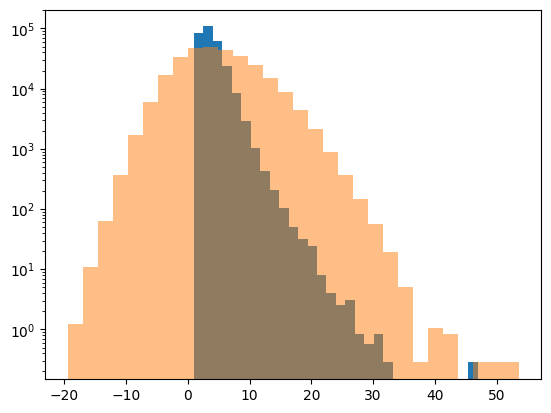

In [8]:
# reweight the sim and data to have the same total weight to begin with
nData, nEmbedding = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])

#wData = np.ones(nData)
#wEmbedding = nData/float(nEmbedding)*np.ones(nEmbedding)

wData = testWts.to_numpy()
wEmbedding = (np.sum(wData)/trainWts.sum()*trainWts).to_numpy()

print(np.sum(wEmbedding), np.sum(wData))
print(np.sum(testWts), np.sum(trainWts))

plt.hist(trainGen["pt"], bins=30, weights=wEmbedding, )
plt.hist(trainReco["pt"], bins=30, weights=wEmbedding, alpha=0.5, label="trainReco")

plt.yscale("log")

now = datetime.now()
nownow = now.strftime("%d-%m-%Y_%H-%M-%S")

folderPath = "savedModels/savedModel_"
unfoldingWeightsFilename = f"{folderPath}/unfoldingWeights"
#logdir = "logs/"+nownow

lossFunc="categorical_crossentropy"
optimizer="adam"
metricList=["accuracy"]
#weightedMetricList = ["categorical_crossentropy"]
weightedMetricList = []

patience=5

validationSize = 0.2
nEpochs = 100
batchSize = 1048

inputShape = X_det.shape[1:]

det_history = []
gen_history = []
w_sim = [wEmbedding]
nIter = 3

weightClipMin = 0.
weightClipMax = np.inf

loadWeights = False

In [9]:
def sequentialDNNMaker(input_shape=None, output_shape=2, layer_sizes=(100, 100), #(100,100,100)
                        dropout=0, **kwargs):
    _model = keras.Sequential()  
    _model.add(keras.Input(shape=input_shape, name="input"))
    #_model.add(layers.Flatten(input_shape=input_shape, name="flatten"))
    for i, size in enumerate(layer_sizes):
        _layer_name = f"hidden_dense_{i}"
        #_layer = layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform", kernel_regularizer=keras.regularizers.L1L2(l2=1e-2))
        _model.add(layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform"))
        _model.add(layers.Activation("relu", name=_layer_name+"_activation"))
        if(dropout > 0):
            _model.add(layers.Dropout(dropout, name=_layer_name+"_dropout"))

    _layer_name = f"output_dense"
    _model.add(layers.Dense(output_shape, name=_layer_name))
    _model.add(layers.Activation("softmax", name=_layer_name+"_activation"))
    
    return _model

def functionalDNNMaker(input_shape=None, output_shape=2, layer_sizes=(100, 100), #(100,100,100)
                       dropout=0, **kwargs):
    _tensors = []
    _tensors.append(layers.Flatten(input_shape=input_shape, name="input"))
    for i, size in enumerate(layer_sizes):
        _layer_name = f"hidden_dense_{i}"
        _layer = layers.Dense(size, name=_layer_name, kernel_initializer="he_uniform")
        _activation = layers.Activation("relu", name=_layer_name+"_activation")
        
        _tensors.append(_layer(_tensors[-1]))
        _tensors.append(_activation(_tensors[-1]))
        if(dropout > 0):
            _dropout = layers.Dropout(0.5, name=_layer_name+"_dropout")
            _tensors.append(_dropout(_tensors[-1]))

    _layer_name = f"output_dense"
    _output_layer = layers.Dense(output_shape, name=_layer_name)
    _output_activation = layers.Activation("softmax", name=_layer_name+"_activation")
    _tensors.append(_output_layer(_tensors[-1]))
    _tensors.append(_output_activation(_tensors[-1]))
    
    _model = keras.Model(inputs=_tensors[0], outputs=_tensors[-1])
    
    return _model

In [10]:

if (loadWeights):
    w_sim = np.load(f"{folderPath}/unfoldingWeights.npy", allow_pickle=True)

else:
    for i in range(nIter):
        detModel = sequentialDNNMaker(input_shape=inputShape)
        detModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
        detCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
        detModelFilePath = folderPath + f"/step1_iteration{i}"+"_epoch{epoch}"
        detCallBacks.append(callbacks.ModelCheckpoint(detModelFilePath, save_best_only=True, verbose=1))
        #detCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

        genModel = sequentialDNNMaker(input_shape=inputShape)
        genModel.compile(loss=lossFunc, optimizer=optimizer, metrics=metricList, weighted_metrics=weightedMetricList)
        genCallBacks = [callbacks.EarlyStopping(patience=patience, verbose=1, restore_best_weights=True)]
        genModelFilePath = folderPath + f"/step2_iteration{i}"+"_epoch{epoch}"
        genCallBacks.append(callbacks.ModelCheckpoint(genModelFilePath, save_best_only=True, verbose=1))
        #genCallBacks.append(callbacks.TensorBoard(log_dir=logdir, histogram_freq=1))

        if(i > 0):
            detModel.load_weights(folderPath + f"/step1_iteration{i-1}")
            genModel.load_weights(folderPath + f"/step2_iteration{i-1}")

        w_det = np.concatenate([wData, w_sim[-1]])
        
        X_det_train, X_det_val, Y_det_train, Y_det_val, w_det_train, w_det_val = train_test_split(X_det, Y_det, w_det, test_size=validationSize)
        detModel.summary()
        det_history.append(detModel.fit(X_det_train, Y_det_train, sample_weight=w_det_train, epochs=nEpochs, batch_size=batchSize, validation_data=(X_det_val, Y_det_val, w_det_val), verbose=1, callbacks=detCallBacks))
        detModel.save_weights(folderPath + f"/step1_iteration{i}")
        
        prediction = detModel.predict(X_det, batch_size=batchSize*10)
        scaleFactors = prediction[Y_det[:, 0] == 1]

        _pull = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
        w_sim.append(_pull)

        w_gen = np.concatenate([w_sim[-1], w_sim[-2]])
        
        X_gen_train, X_gen_val, Y_gen_train, Y_gen_val, w_gen_train, w_gen_val = train_test_split(X_gen, Y_gen, w_gen, test_size=validationSize)
        genModel.summary()
        gen_history.append(genModel.fit(X_gen_train, Y_gen_train, sample_weight=w_gen_train, epochs=nEpochs, batch_size=5*batchSize, validation_data=(X_gen_val, Y_gen_val, w_gen_val), verbose=1, callbacks=genCallBacks))
        genModel.save_weights(folderPath + f"/step2_iteration{i}")
        
        prediction = genModel.predict(X_gen, batch_size=batchSize*50)
        scaleFactors = prediction[Y_gen[:, 0] == 1]

        _push = np.clip(scaleFactors[:, 1]/(scaleFactors[:, 0]+ 10**-50), weightClipMin, weightClipMax)*w_sim[-1]
        w_sim.append(_push)
        
        np.save(unfoldingWeightsFilename, w_sim)

#filename = f"outputs/multifoldClosure_{patience}_{batchSize}_{nEpochs}_{nIter}_{nownow}.root"
#outFile = uproot.recreate(filename)
#print("Saving to file: ", filename)

#trainGen["wt"] = w_sim[2*nIter]
#outFile["unfolded"] = trainGen
#outFile["reco"] = testReco
#outFile["gen"] = testGen
    

wu=w_sim

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_dense_0 (Dense)      (None, 100)               700       
                                                                 
 hidden_dense_0_activation   (None, 100)               0         
 (Activation)                                                    
                                                                 
 hidden_dense_1 (Dense)      (None, 100)               10100     
                                                                 
 hidden_dense_1_activation   (None, 100)               0         
 (Activation)                                                    
                                                                 
 output_dense (Dense)        (None, 2)                 202       
                                                                 
 output_dense_activation (A  (None, 2)                 0

2024-02-05 15:57:20.993282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-05 15:57:21.058200: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557cae4b0c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-05 15:57:21.058260: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-02-05 15:57:21.143844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-05 15:57:21.266688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-02-05 15:57:21.695500: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-05 

1106/1113 [============================>.] - ETA: 0s - loss: 0.2776 - accuracy: 0.5040
Epoch 1: val_loss improved from inf to 0.27760, saving model to savedModels/savedModel_/step1_iteration0_epoch1
1113/1113 [==============================] - 14s 8ms/step - loss: 0.2776 - accuracy: 0.5046 - val_loss: 0.2776 - val_accuracy: 0.6425
Epoch 2/100
1110/1113 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.5162
Epoch 2: val_loss did not improve from 0.27760
1113/1113 [==============================] - 8s 7ms/step - loss: 0.2774 - accuracy: 0.5161 - val_loss: 0.2779 - val_accuracy: 0.4738
Epoch 3/100
1109/1113 [============================>.] - ETA: 0s - loss: 0.2774 - accuracy: 0.5047
Epoch 3: val_loss improved from 0.27760 to 0.27756, saving model to savedModels/savedModel_/step1_iteration0_epoch3
1113/1113 [==============================] - 9s 8ms/step - loss: 0.2774 - accuracy: 0.5055 - val_loss: 0.2776 - val_accuracy: 0.7147
Epoch 4/100
1113/1113 [=================

In [11]:
w_sim[2*nIter]


array([0.22617963, 0.19897909, 0.22681905, ..., 0.25054111, 0.24951745,
       0.2422648 ])

## Plot Unfolding Results

Now it's time to plot the unfolding results for all of the specified observables!

In [24]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})


# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (-1, 30),  'ylim': (0.00003, 10),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.425, 0.75),
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0.1, 1.001),   'ylim': (0, 3),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.8),  'ylim': (0, 6),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda_1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_1half', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.4),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda_1_1half$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_2', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.2),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda_1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda_1_3', {}).update({
    'func': lambda dset, type: dset[type],
    'nbins_det': 20, 'nbins_mc': 50,
    'xlim': (0, 0.1),  'ylim': (0, 10),
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda_1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})


# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}


for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]



    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
  
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]
  
   
    print('Done with', obkey)


Done with pt
Done with z
Done with lambda_1_1
Done with lambda_1_1half
Done with lambda_1_2
Done with lambda_1_3


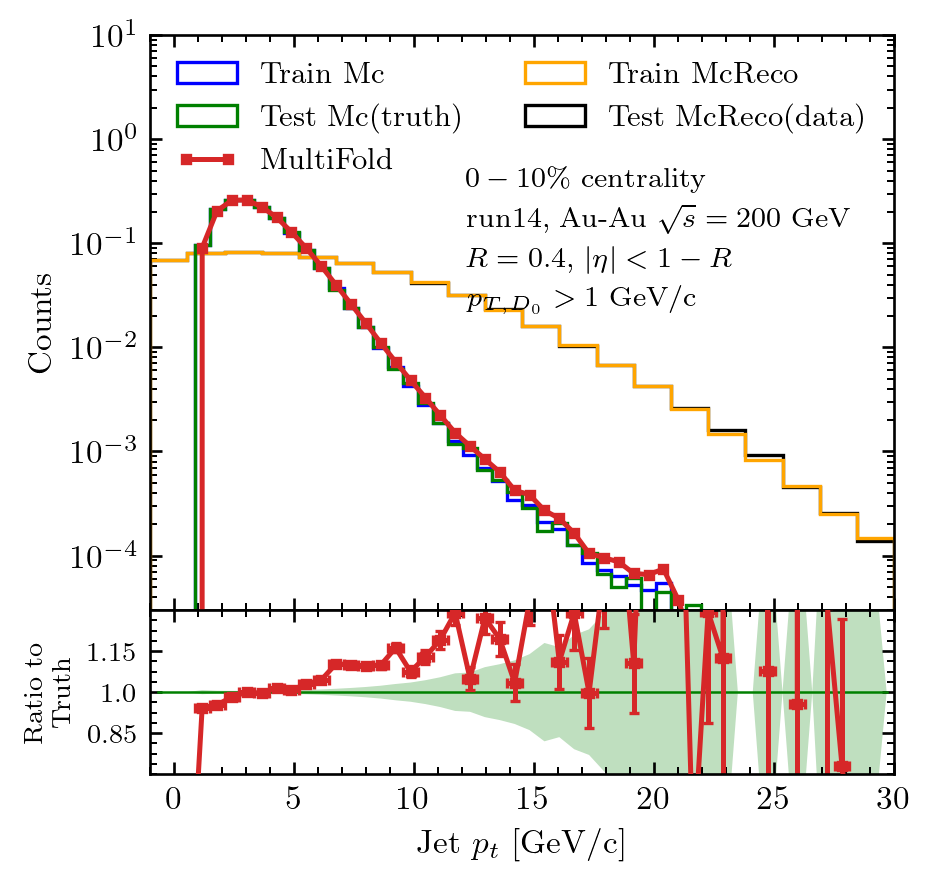

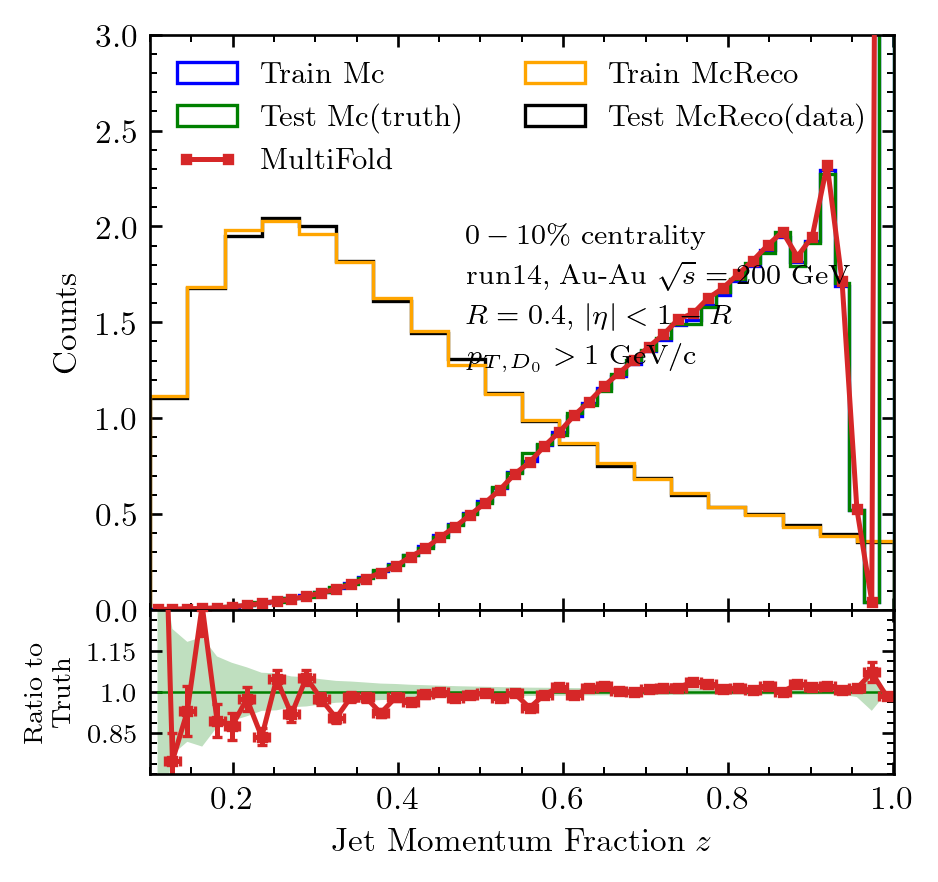

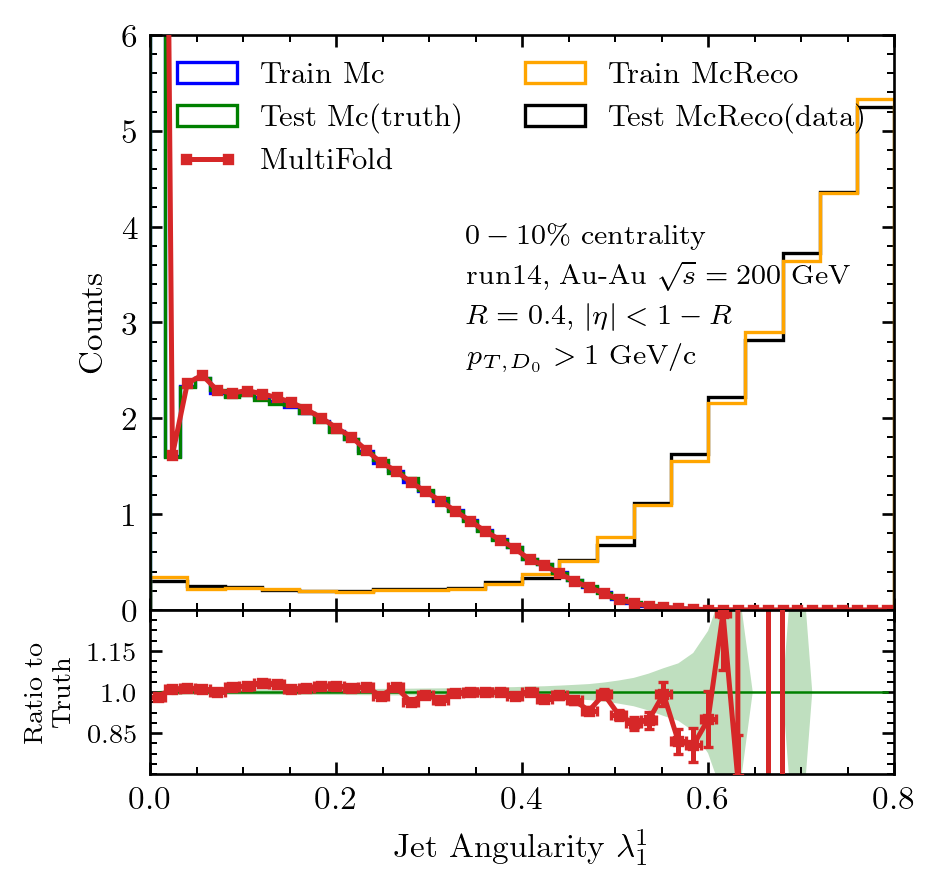

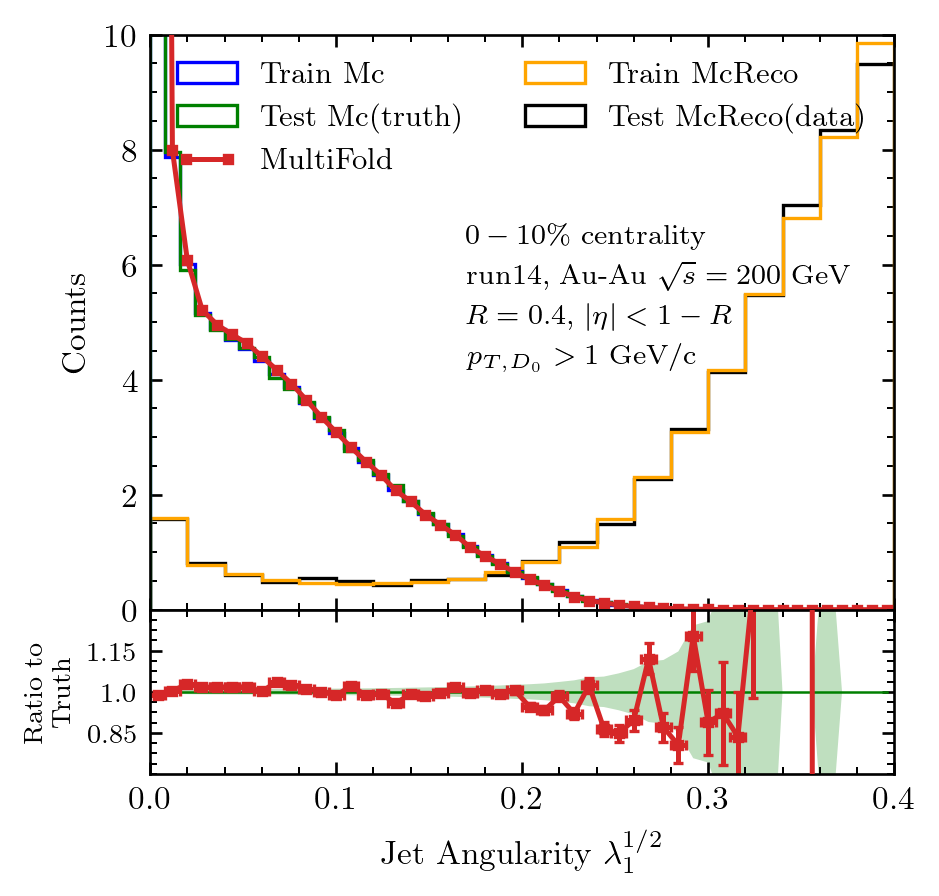

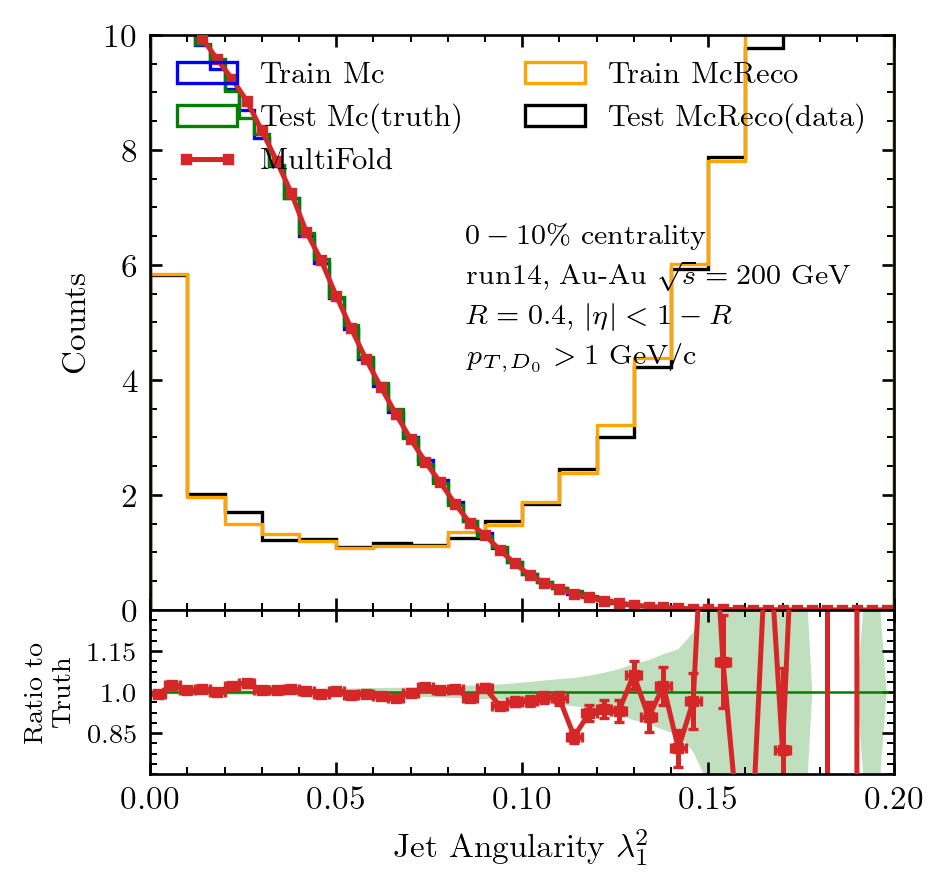

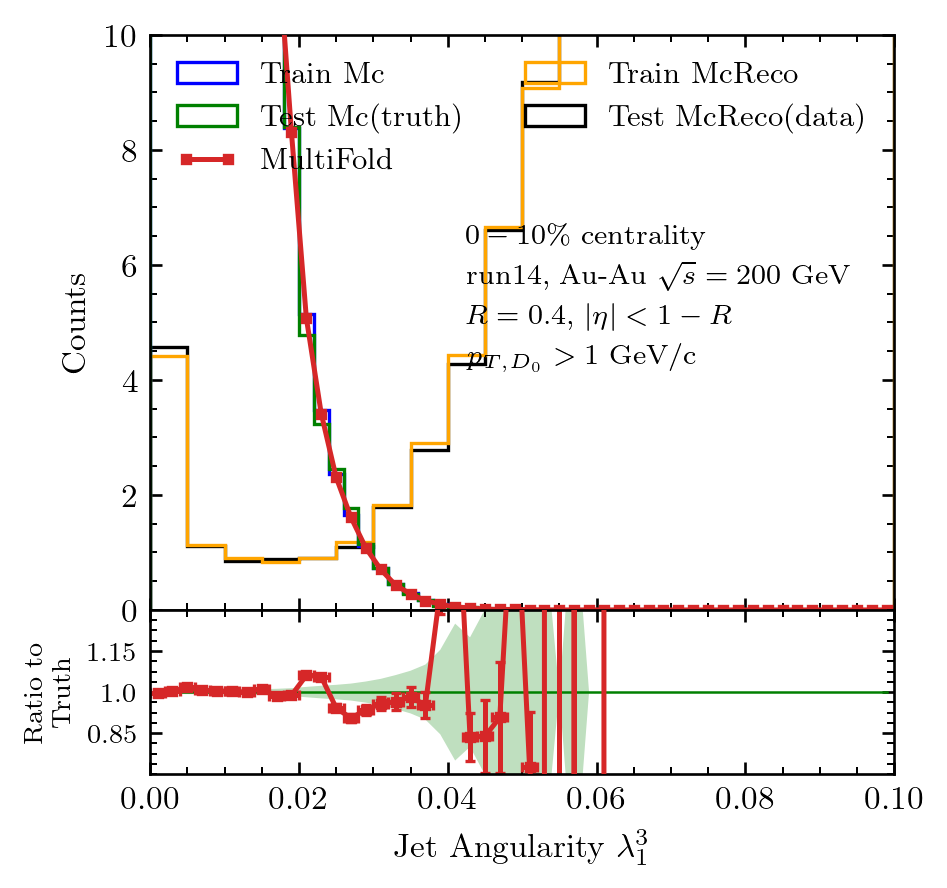

In [25]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])


    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='Test McReco(data)', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Train McReco', **hist_style)


    ax0.hist(ob['genobs'], bins=ob['bins_mc'], color='blue', label='Train Mc', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['truthobs'], bins=ob['bins_mc'], color='green', label='Test Mc(truth)', **hist_style)


    # # # plot the "gen" histogram of the observable
    # ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # # plot the "truth" histogram of the observable
    # ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=w_sim[2*nIter], bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)

    of_ratio = of_histgen/(ob['truth_hist']+ 10**-50)
    ax1.plot(ob['midbins_mc'], of_ratio, **omnifold_style)

    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)

    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)

    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [2, 3, 4, 1, 0] 
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol,fontsize = 9)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.07, ax=ax0,
                  line_0=r'$0-10 \%$ centrality',
                  line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                  line_2=r'$R=0.4$, $|\eta|<1-R$',
                  line_3=r'$p_{T,D_0}>1$ GeV/c')


    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    plt.show()

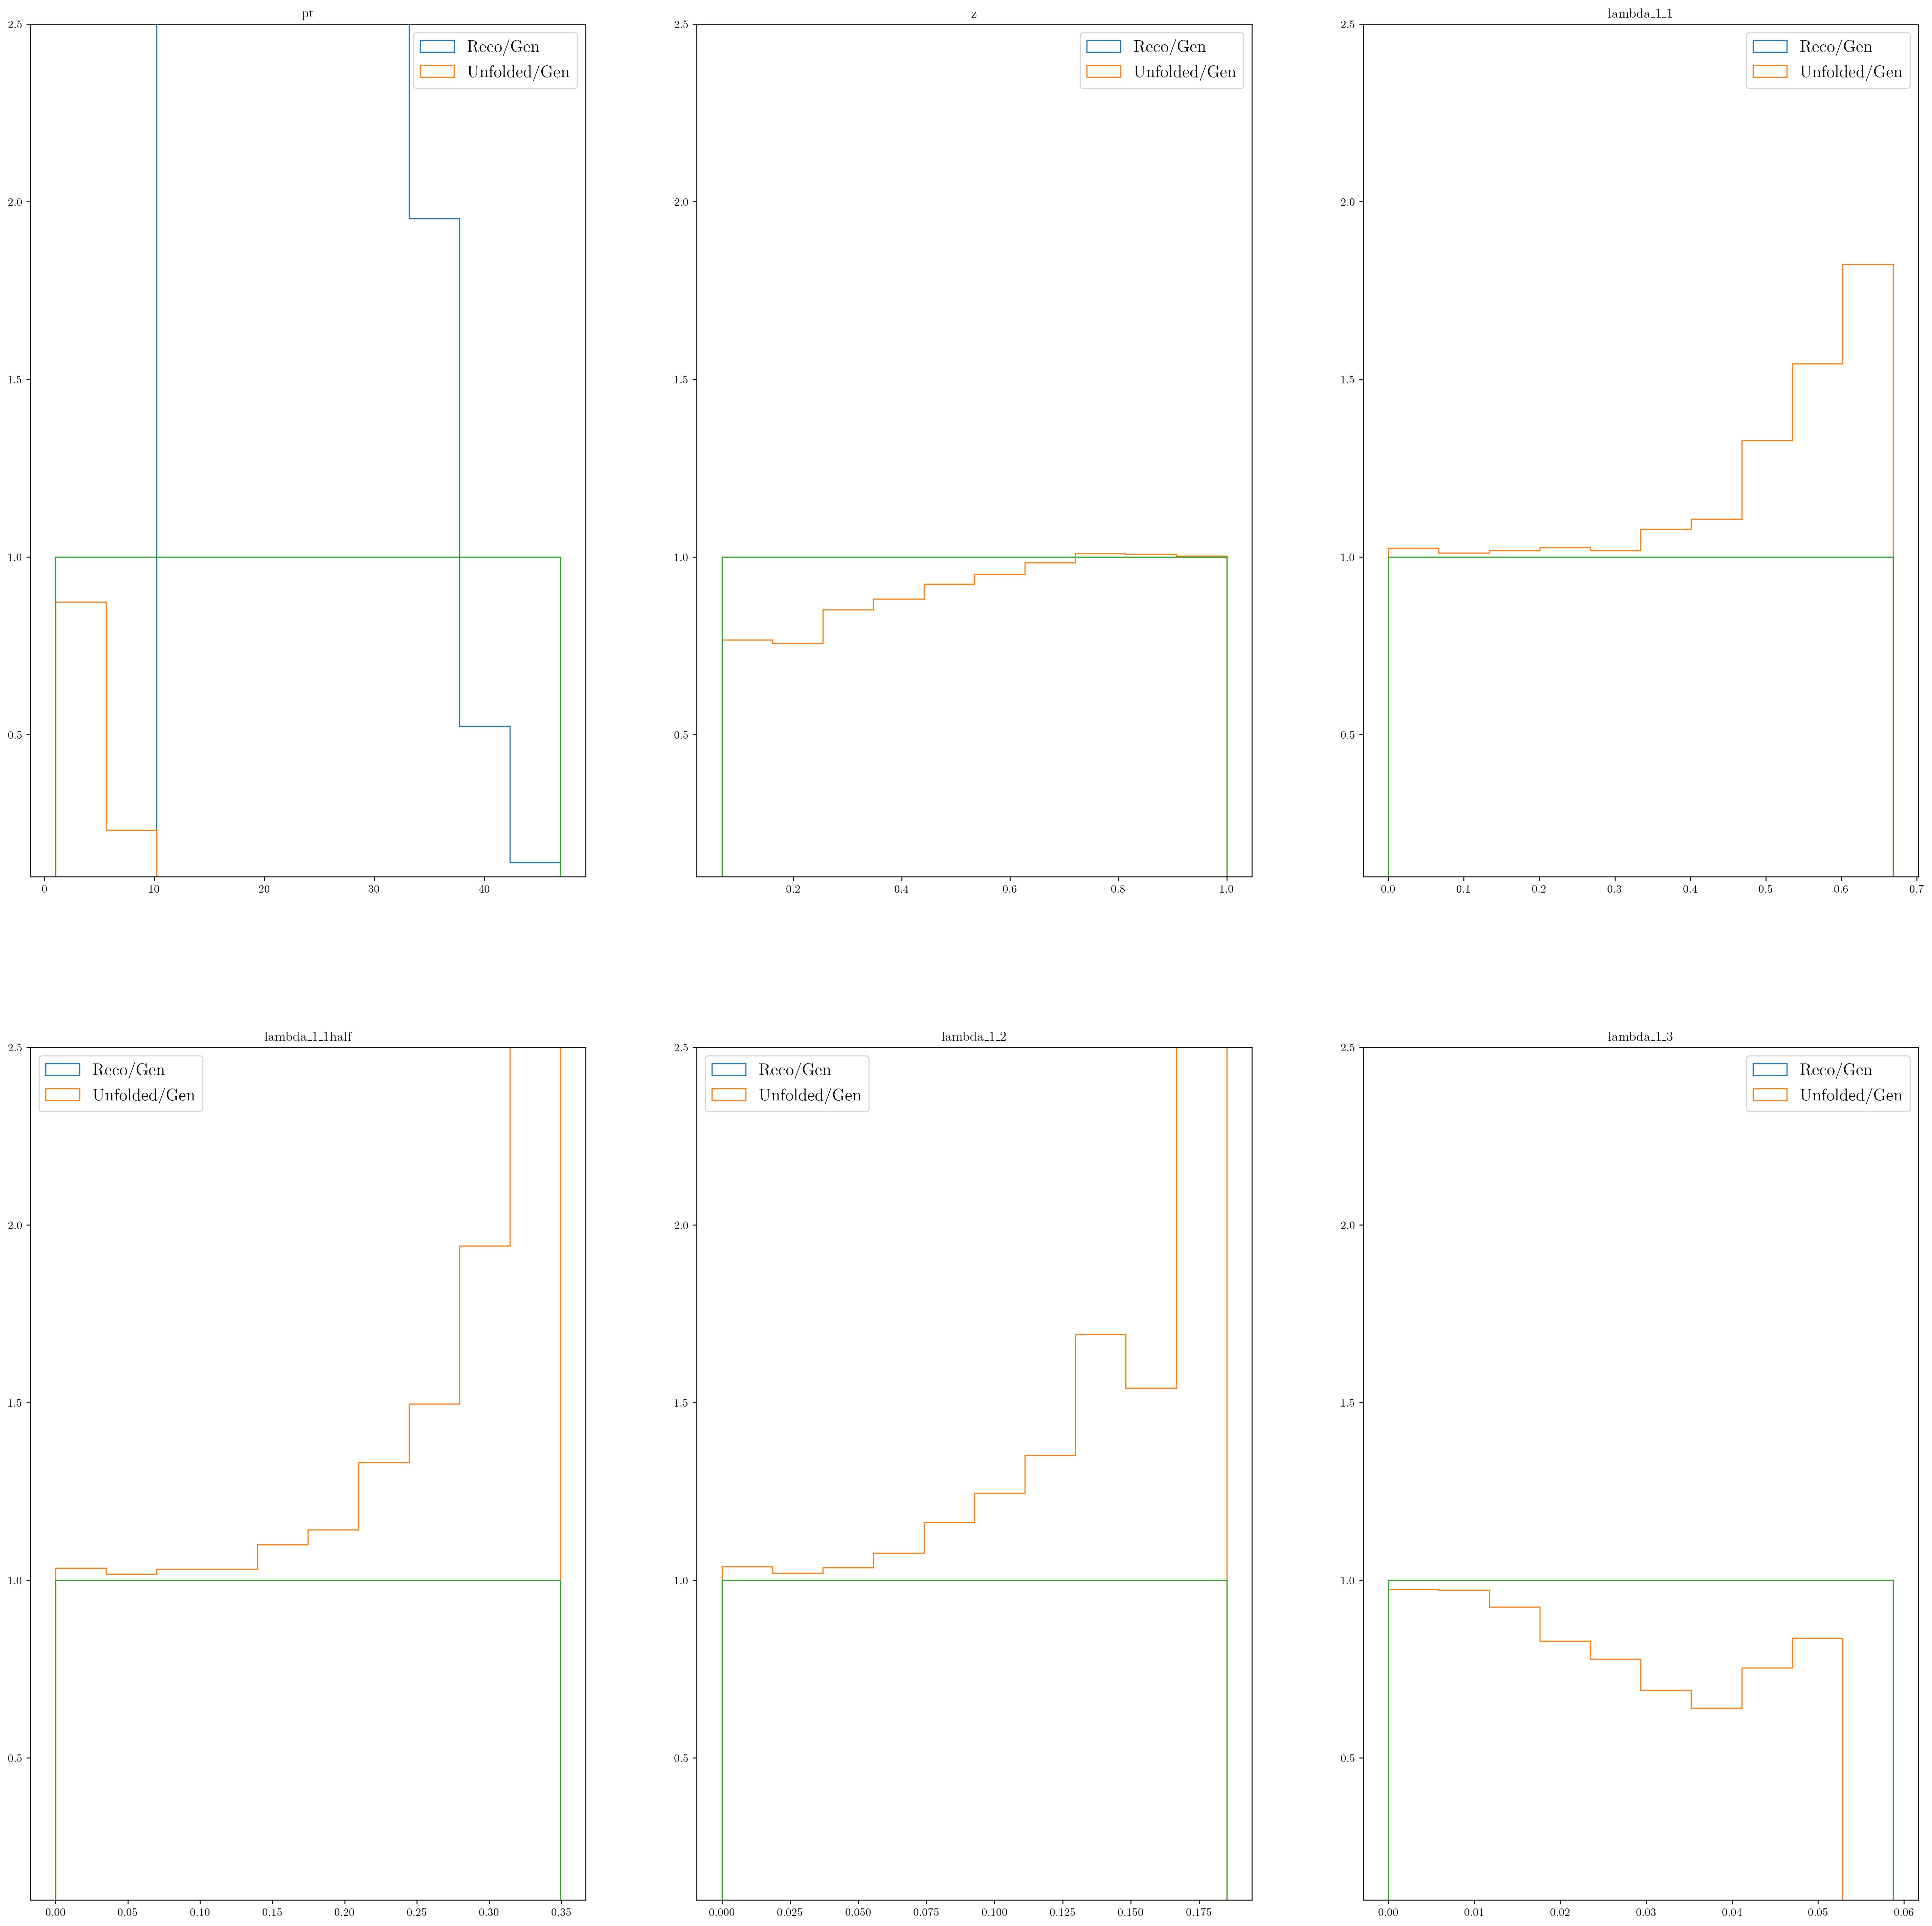

In [18]:
_iter = 2
nRows = 2
nColumns = 3
fig, ax = plt.subplots(nRows, nColumns, figsize=(30., 30.))
for i, feature in enumerate(features):
    row = int(i/nColumns)
    column = i%nColumns 
        
    histGen, bins = np.histogram(testGen[feature], weights=wData, density=True)
    histReco, bins = np.histogram(testReco[feature], weights=wData, density=True) 
    histUnfolded, bins = np.histogram(trainGen[feature], weights=wu[2*_iter], density=True)
        
    ax[row, column].hist(bins[:-1], bins, weights=histReco/histGen, label="Reco/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=histUnfolded/histGen, label="Unfolded/Gen", histtype="step")
    ax[row, column].hist(bins[:-1], bins, weights=np.ones((bins.shape[0]-1)), histtype="step")
    ax[row, column].set_title(feature)
    ax[row, column].set_ylim(0.1, 2.5)
    ax[row, column].legend(prop={'size': 15})
        

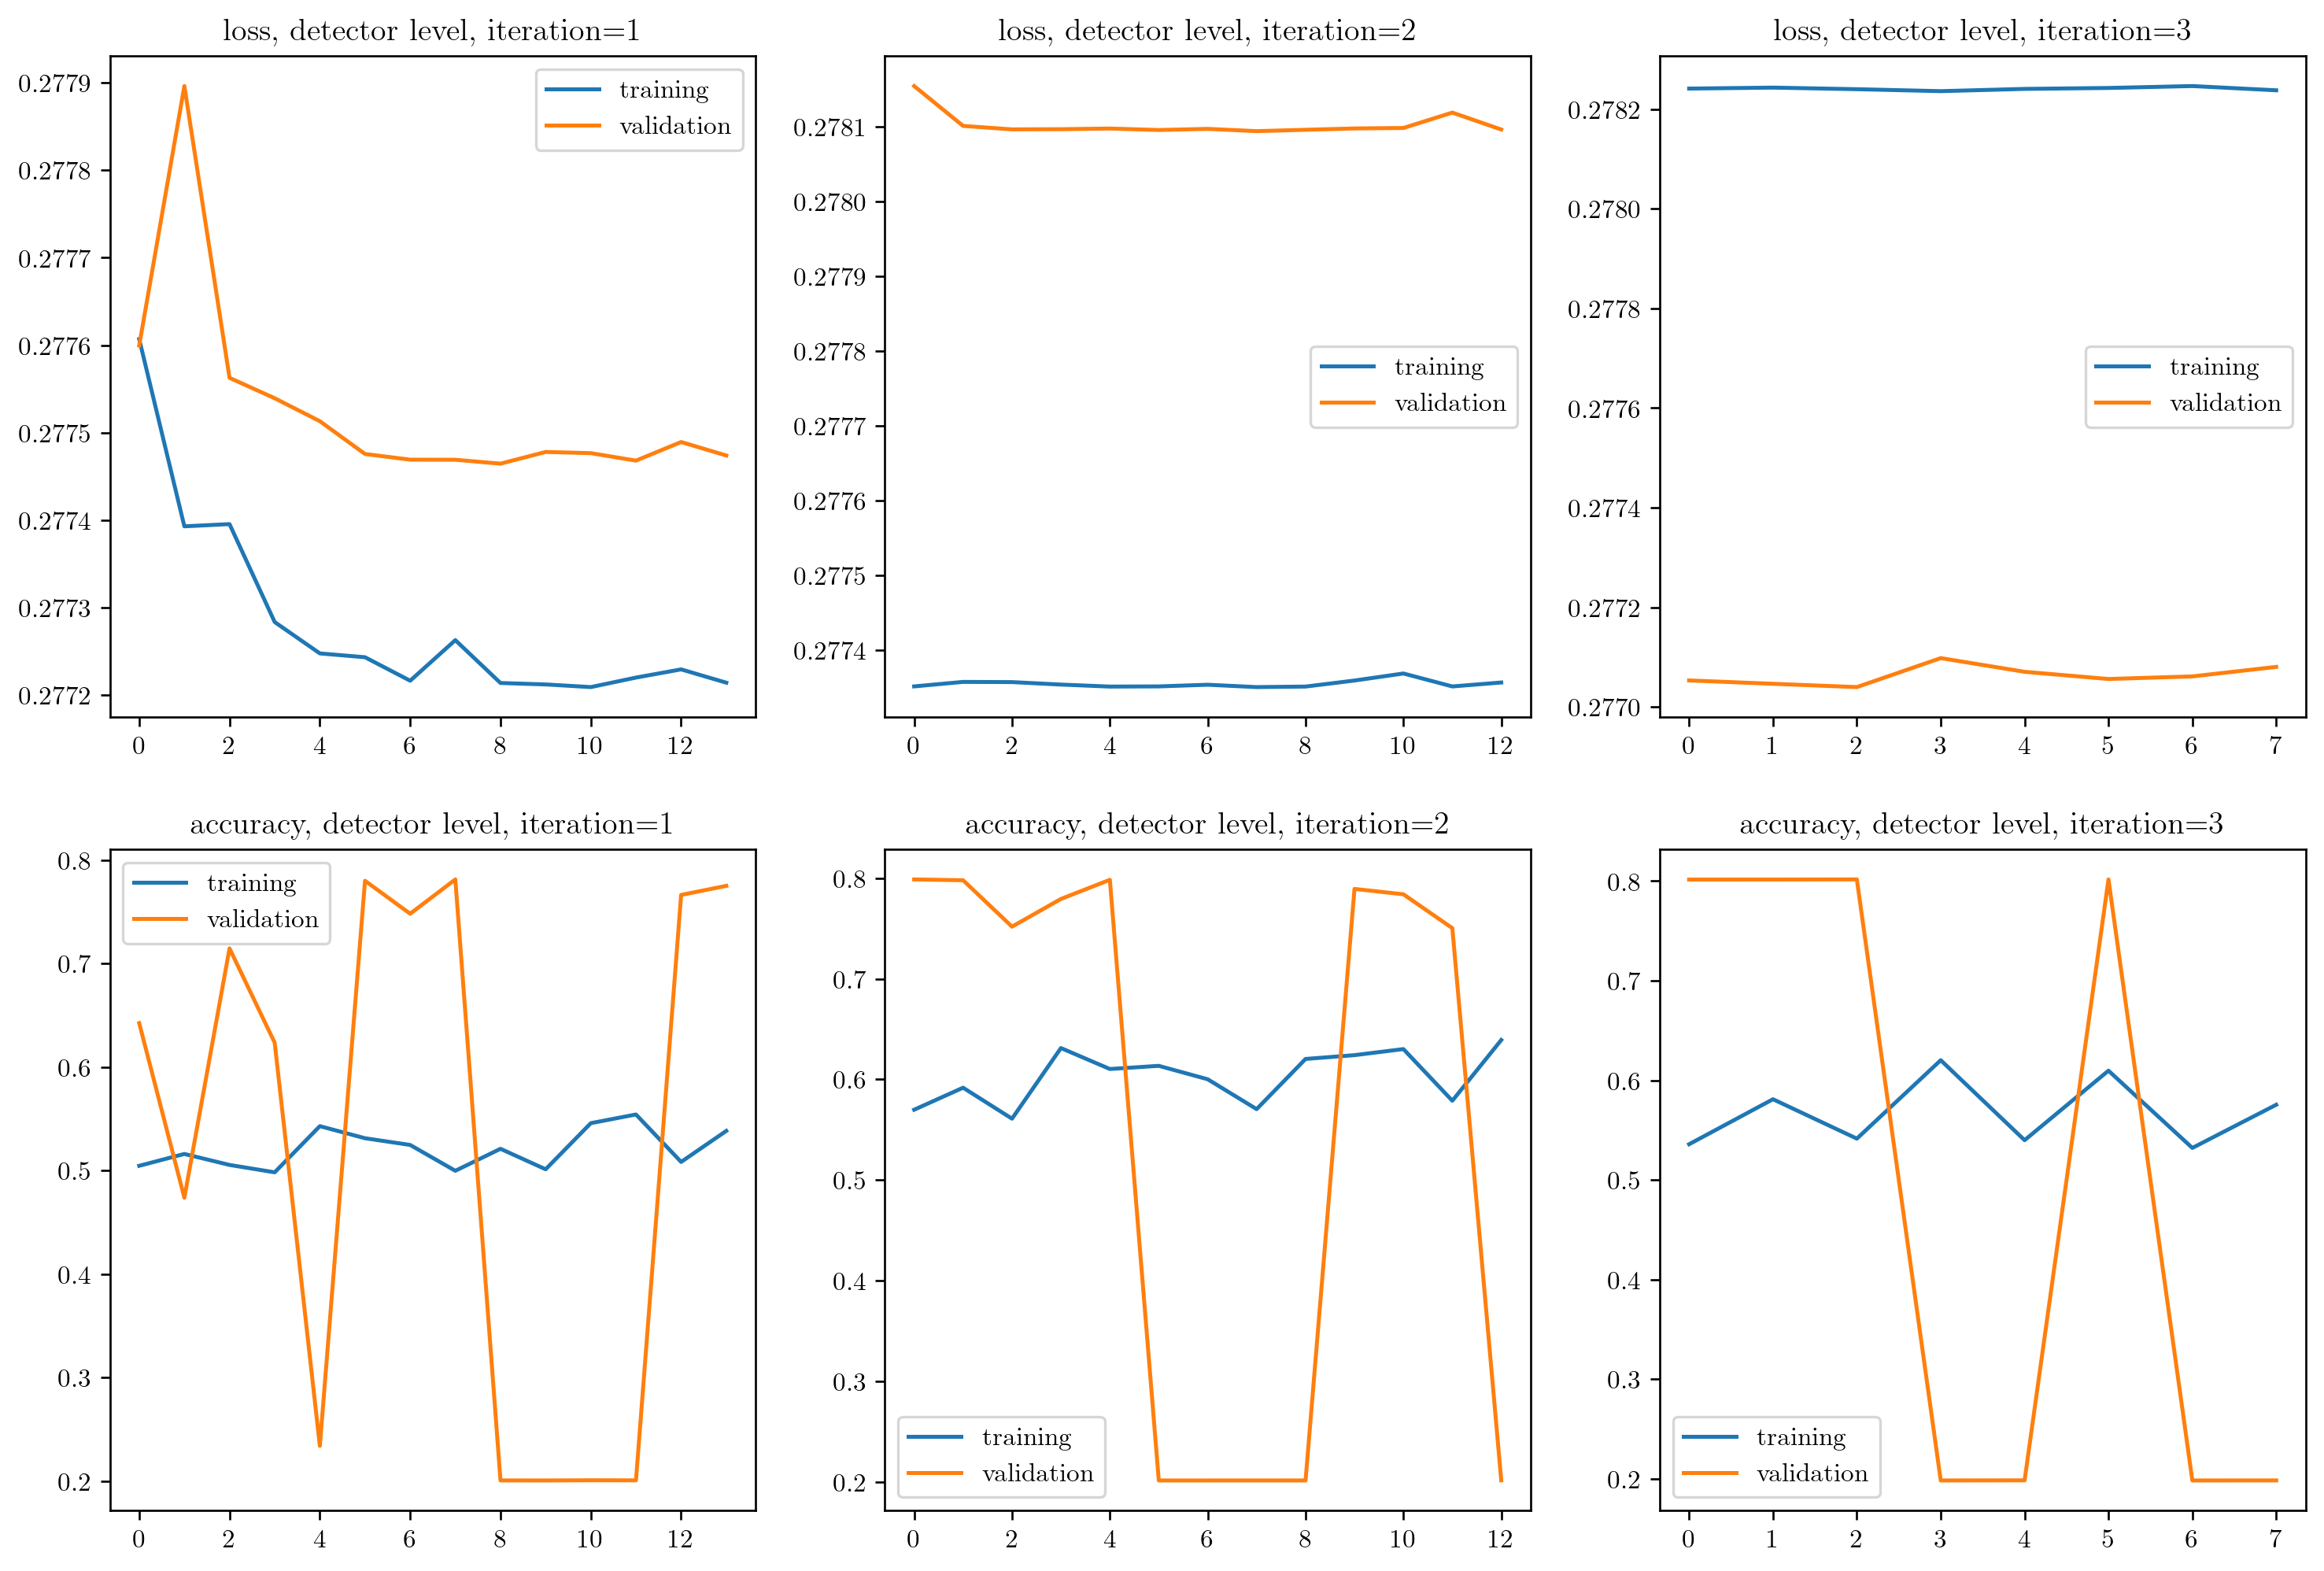

In [15]:
_nIter = 3

#metrics = ["loss", "accuracy", "categorical_crossentropy"]
metrics = ["loss", "accuracy"]
detfig, detax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        detax[row, column].plot(det_history[column].history[metricName], label="training")
        detax[row, column].plot(det_history[column].history["val_"+metricName], label="validation")
        detax[row, column].set_title(metricName+f", detector level, iteration={column+1}")
        #detax[row, column].set_ylim(0.25, 0.32)
        detax[row, column].legend()
        
        

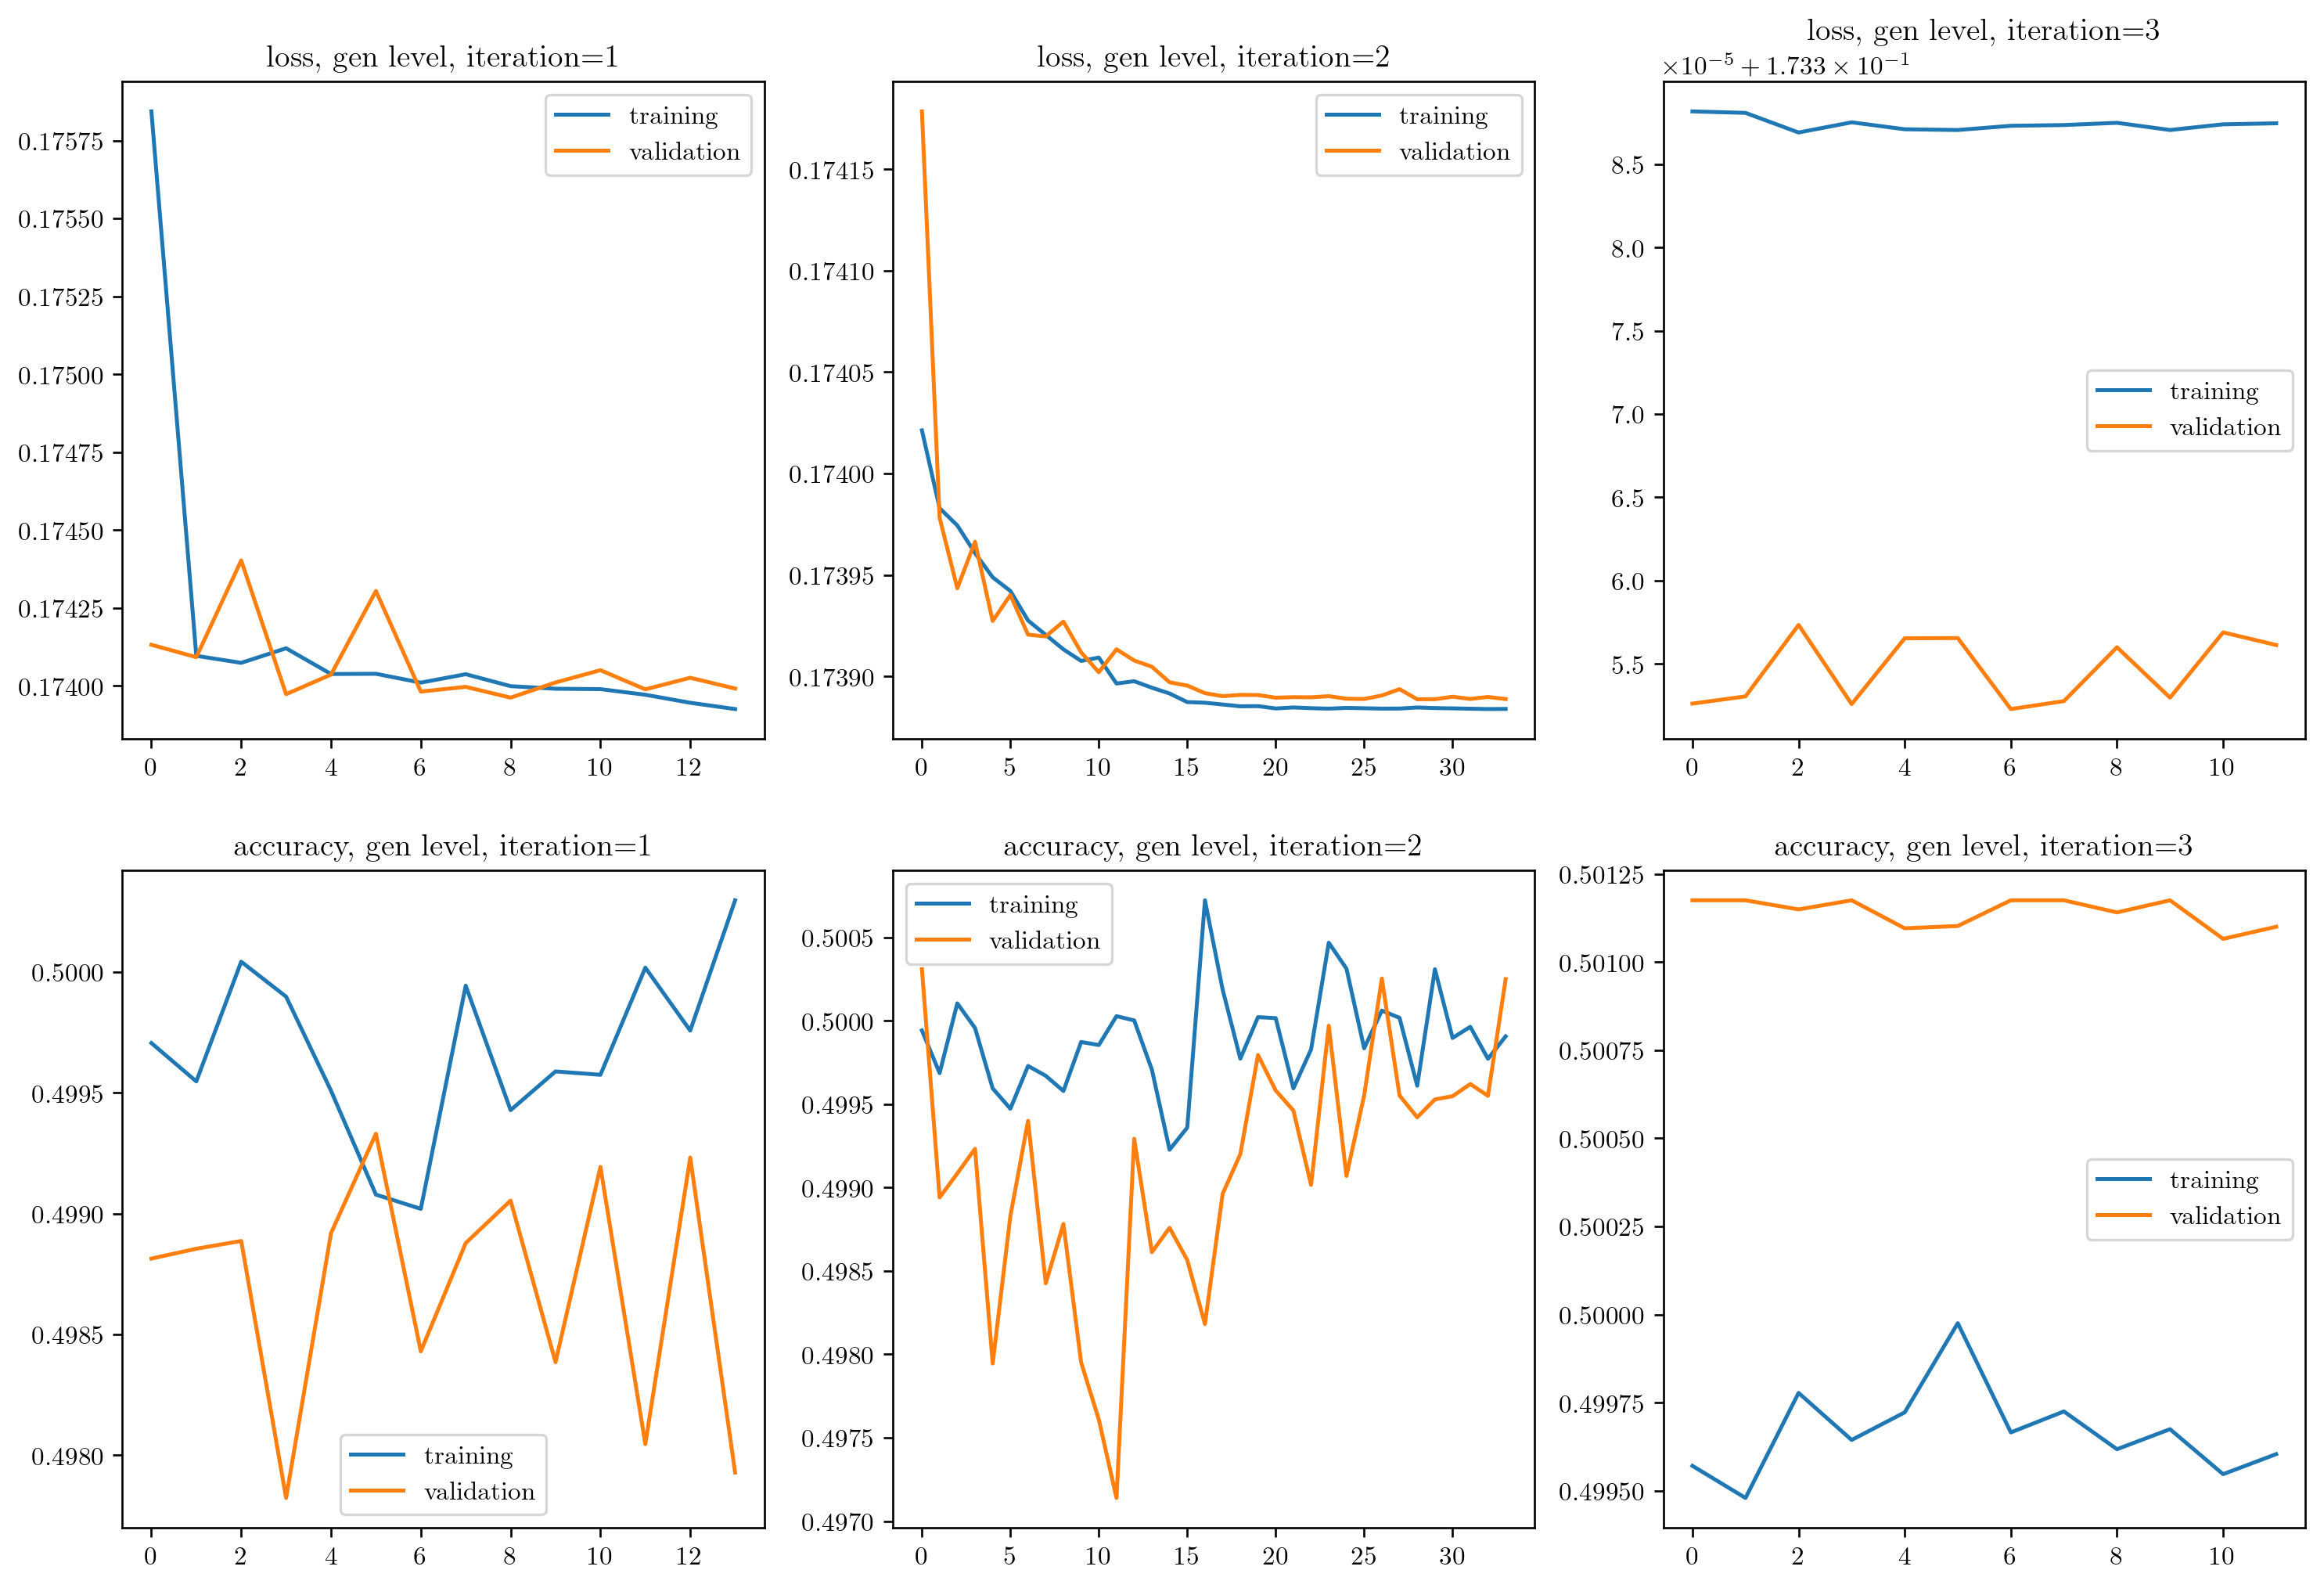

In [16]:
genfig, genax = plt.subplots(len(metrics), _nIter, figsize=(_nIter*5., len(metrics)*5.))
for row, metricName in enumerate(metrics):
    for column in range(_nIter):
        genax[row, column].plot(gen_history[column].history[metricName], label="training")
        genax[row, column].plot(gen_history[column].history["val_"+metricName], label="validation")
        genax[row, column].set_title(metricName+f", gen level, iteration={column+1}")
        genax[row, column].legend()